# ANLY-605 Fall 2022 Project Step II

<p align='center'>
<b>
Jingsong Gao (jg2109), Ercong Luo (el890), Rui Qiu (rq47)
</b>
</p>

<p align='center'><b>2022-09-28</b></p>

## Setup and Data Preparation

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Load keywords and labels

data = {
    "train": pd.concat(
        [
            pd.read_csv("../data/wine_keywords_train.csv"),
            pd.read_csv("../data/wine_keywords_val.csv"),
        ]
    ),
    "test": pd.read_csv("../data/wine_keywords_test.csv"),
}

In [3]:
# Load label to index mapping
import json

with open("../models/label_to_idx.json", "r") as f:
    label_to_idx = json.load(f)

data["train"]["region_variety"] = data["train"]["region_variety"].map(
    lambda x: label_to_idx[x]
)
data["test"]["region_variety"] = data["test"]["region_variety"].map(
    lambda x: label_to_idx[x]
)

In [4]:
data["train"].head()

,keywords,region_variety
0,core adequate acidity moderate extraction medi...,265
1,complexity varietal character black plum light...,17
2,rhubarb cranberry fruit red apple light simple...,4
3,impressive fullness ripeness black cherry leat...,251
4,dusty tones mineral saffron pollen concentrate...,11


In [5]:
# Sample with replacement to select a subset of the data, making sure each class has 20 samples.
data_slim = (
    data["train"]
    .groupby("region_variety")
    .apply(lambda x: x.sample(20, random_state=42, replace=True))
    .reset_index(drop=True)
)

In [6]:
data_slim.describe()

,region_variety
count,11680.000000
mean,291.500000
std,168.593249
min,0.000000
25%,145.750000
50%,291.500000
75%,437.250000
max,583.000000


In [7]:
# Count vectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(data_slim["keywords"])

train_vectors = vectorizer.transform(data_slim["keywords"])
test_vectors = vectorizer.transform(data["test"]["keywords"])

In [8]:
print("Vectorizer #features:", len(vectorizer.get_feature_names()))
print("Vectorizer features:", vectorizer.get_feature_names()[500:600])

Vectorizer #features: 6081
Vectorizer features: ['bell', 'bellangelo', 'belzbrunnen', 'benito', 'benjamin', 'berenguer', 'beresan', 'bergamot', 'bergerac', 'bernard', 'berried', 'berries', 'berry', 'berryish', 'berrylicious', 'bertani', 'best', 'better', 'betz', 'beverage', 'bianca', 'bianco', 'biancolella', 'bical', 'bieler', 'bienenberg', 'big', 'bigger', 'biggest', 'bigtime', 'bilberry', 'bill', 'billards', 'billing', 'billo', 'bing', 'biodynamic', 'biodynamically', 'birch', 'bird', 'birds', 'biscotti', 'biscuit', 'biscuits', 'biscuity', 'bisquertt', 'bistro', 'bite', 'bites', 'biting', 'bitner', 'bits', 'bitter', 'bitterness', 'bitters', 'bittersweet', 'black', 'blackberries', 'blackberrry', 'blackberry', 'blackcurrant', 'blackened', 'blackness', 'blacktop', 'blanc', 'blanca', 'blanched', 'blanco', 'blancs', 'bland', 'blangé', 'blasting', 'blatant', 'blaufränkisch', 'blaye', 'blazing', 'blend', 'blended', 'blending', 'blends', 'bleue', 'blind', 'bliss', 'blockbuster', 'blockier', '

/Users/rqiu/Library/Caches/pypoetry/virtualenvs/sommelier-app-LnLhopHO-py3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [9]:
random_state = 42

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, top_k_accuracy_score
from tqdm import tqdm
from sklearn.metrics import confusion_matrix


def top_5_acc(estimator, X, y):
    try:
        y_pred_proba = estimator.predict_proba(X)
    except AttributeError:
        y_pred_proba = estimator.decision_function(X)
    return top_k_accuracy_score(y, y_pred_proba, k=5)


def eval_model(model, X, y, n_jobs=-1):
    """Evaluate a list of models using cross-validation.

    Args:
        models (dict): A dictionary of models to evaluate.
        X (array-like): Training data.
        y (array-like): Training labels.

    Returns:
        scores (list): Dictionary of scores (another dict) for each model.
    """
    # for name, model in tqdm(models.items()):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    cv_scores = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=top_5_acc,
        n_jobs=n_jobs,
        verbose=1,
        return_train_score=True,
    )

    print(
        f"[Train] Top-5 prediction mean accuracy: {cv_scores['train_score'].mean():.3f} (+/- {cv_scores['train_score'].std() * 2:.3f})"
    )
    print(
        f"[Test] Top-5 prediction mean accuracy: {cv_scores['test_score'].mean():.3f} (+/- {cv_scores['test_score'].std() * 2:.3f})"
    )
    return cv_scores

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [11]:
# Create a dictionary of models
scores = dict()

In [12]:
# evaluate naïve bayes
nb = MultinomialNB()
scores["nb"] = eval_model(nb, train_vectors, data_slim["region_variety"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


[Train] Top-5 prediction mean accuracy: 0.972 (+/- 0.001)
[Test] Top-5 prediction mean accuracy: 0.503 (+/- 0.016)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


In [13]:
import matplotlib.pyplot as plt

nb.fit(train_vectors, data_slim["region_variety"])

MultinomialNB()

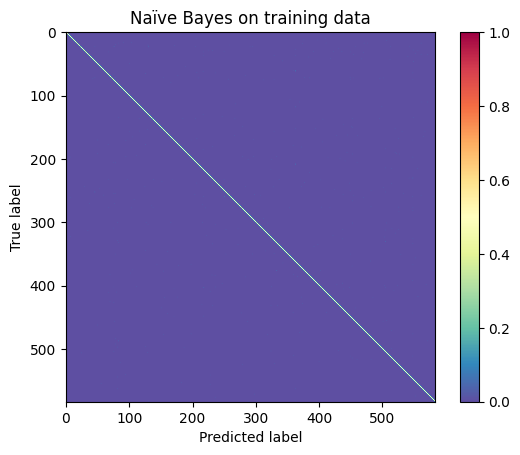

In [14]:
def plot_conf_matrix(y_true, y_pred, title, filename):
    """Plot confusion matrix."""
    conf_mat = confusion_matrix(y_true, y_pred)
    conf_mat = conf_mat.astype("float") / conf_mat.sum(axis=1)[:, np.newaxis]
    plt.imshow(conf_mat, cmap="Spectral_r")
    plt.colorbar()
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(title)
    plt.savefig(filename, bbox_inches="tight")


def predict_top5(estimator, X, y_true):
    # Predict probabilities, if y true in top 5, return y_true, else the first in top 5
    try:
        y_pred_proba = estimator.predict_proba(X)
    except AttributeError:
        y_pred_proba = estimator.decision_function(X)
    y_pred = np.array(
        [y_pred_proba[i].argsort()[-5:][::-1] for i in range(len(y_pred_proba))]
    )
    y_pred = np.array(
        [
            y_true[i] if y_true[i] in y_pred[i] else y_pred[i][0]
            for i in range(len(y_pred))
        ]
    )
    return y_pred


plot_conf_matrix(
    data_slim["region_variety"],
    predict_top5(nb, train_vectors, data_slim["region_variety"]),
    "Naïve Bayes on training data",
    "../img/confusion_matrix_nb_train.png",
)

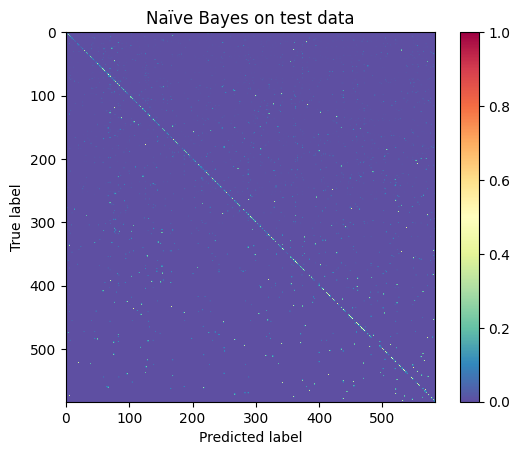

In [15]:
plot_conf_matrix(
    data["test"]["region_variety"],
    predict_top5(nb, test_vectors, data["test"]["region_variety"]),
    "Naïve Bayes on test data",
    "../img/confusion_matrix_nb_test.png",
)

In [16]:
# evaluate perceptron
perceptron = Perceptron(random_state=random_state, early_stopping=True)
scores["perceptron"] = eval_model(
    perceptron, train_vectors, data_slim["region_variety"]
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


[Train] Top-5 prediction mean accuracy: 0.936 (+/- 0.002)
[Test] Top-5 prediction mean accuracy: 0.415 (+/- 0.021)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


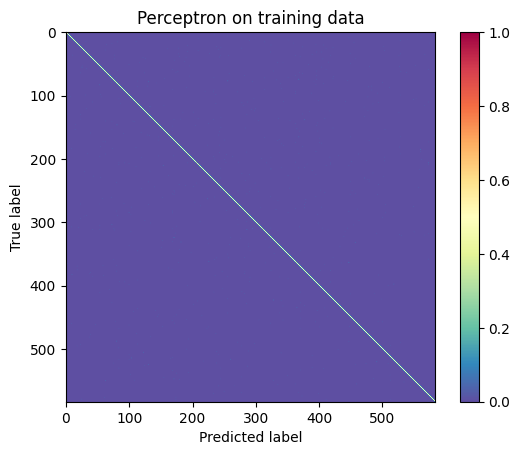

In [17]:
perceptron.fit(train_vectors, data_slim["region_variety"])

plot_conf_matrix(
    data_slim["region_variety"],
    predict_top5(perceptron, train_vectors, data_slim["region_variety"]),
    "Perceptron on training data",
    "../img/confusion_matrix_perceptron_train.png",
)

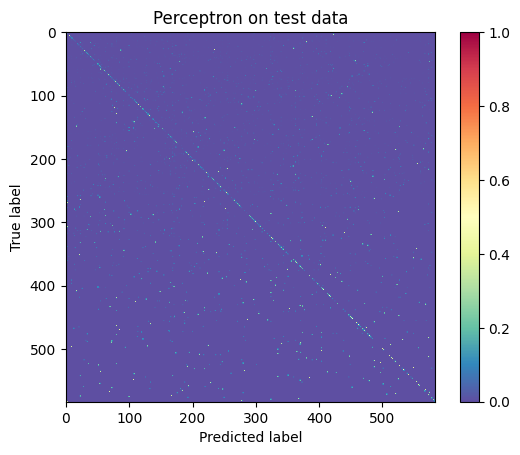

In [18]:
plot_conf_matrix(
    data["test"]["region_variety"],
    predict_top5(perceptron, test_vectors, data["test"]["region_variety"]),
    "Perceptron on test data",
    "../img/confusion_matrix_perceptron_test.png",
)

In [19]:
# evaluate linear SVM
svm = LinearSVC(random_state=random_state)
scores["svm"] = eval_model(svm, train_vectors, data_slim["region_variety"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


[Train] Top-5 prediction mean accuracy: 1.000 (+/- 0.000)
[Test] Top-5 prediction mean accuracy: 0.478 (+/- 0.020)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


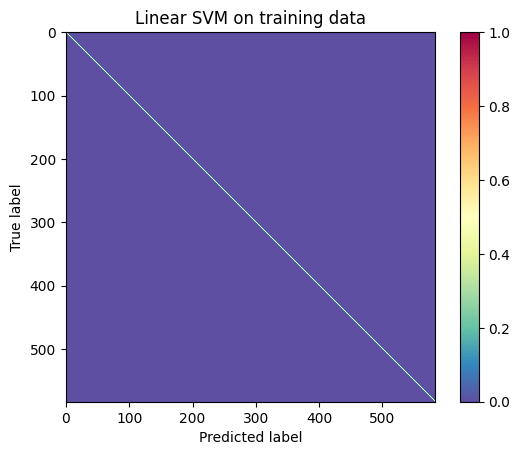

In [20]:
svm.fit(train_vectors, data_slim["region_variety"])

plot_conf_matrix(
    data_slim["region_variety"],
    predict_top5(svm, train_vectors, data_slim["region_variety"]),
    "Linear SVM on training data",
    "../img/confusion_matrix_svm_train.png",
)

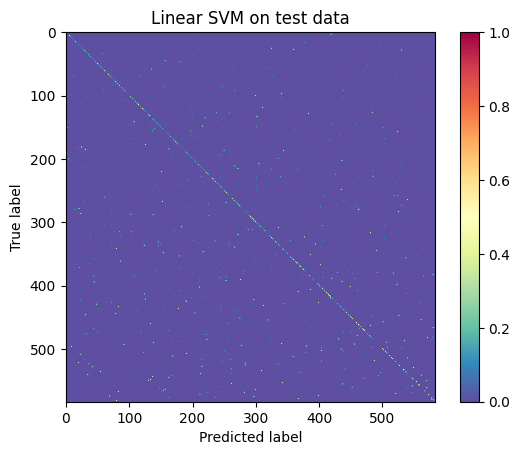

In [21]:
plot_conf_matrix(
    data["test"]["region_variety"],
    predict_top5(svm, test_vectors, data["test"]["region_variety"]),
    "Linear SVM on test data",
    "../img/confusion_matrix_svm_test.png",
)

In [35]:
# evaluate decision tree
tree = DecisionTreeClassifier(random_state=random_state, max_depth=600)
scores["tree"] = eval_model(tree, train_vectors, data_slim["region_variety"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


[Train] Top-5 prediction mean accuracy: 1.000 (+/- 0.000)
[Test] Top-5 prediction mean accuracy: 0.382 (+/- 0.012)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished


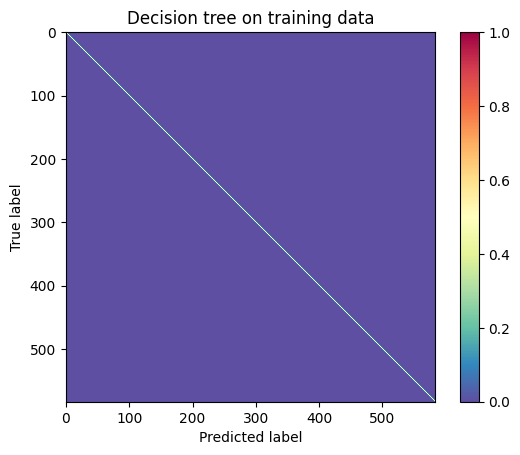

In [36]:
tree.fit(train_vectors, data_slim["region_variety"])

plot_conf_matrix(
    data_slim["region_variety"],
    predict_top5(tree, train_vectors, data_slim["region_variety"]),
    "Decision tree on training data",
    "../img/confusion_matrix_tree_train.png",
)

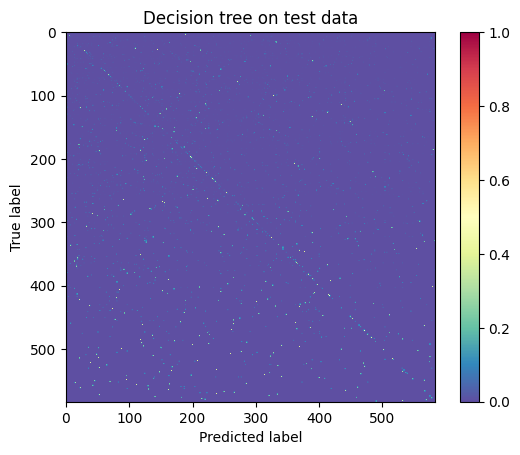

In [37]:
plot_conf_matrix(
    data["test"]["region_variety"],
    predict_top5(tree, test_vectors, data["test"]["region_variety"]),
    "Decision tree on test data",
    "../img/confusion_matrix_tree_test.png",
)

In [25]:
# evaluate logistic regression

logreg = LogisticRegression(random_state=random_state, max_iter=80, solver="saga")
scores["logreg"] = eval_model(logreg, train_vectors, data_slim["region_variety"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/rqiu/Library/Caches/pypoetry/virtualenvs/sommelier-app-LnLhopHO-py3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rqiu/Library/Caches/pypoetry/virtualenvs/sommelier-app-LnLhopHO-py3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rqiu/Library/Caches/pypoetry/virtualenvs/sommelier-app-LnLhopHO-py3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rqiu/Library/Caches/pypoetry/virtualenvs/sommelier-app-LnLhopHO-py3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coe

[Train] Top-5 prediction mean accuracy: 0.998 (+/- 0.000)
[Test] Top-5 prediction mean accuracy: 0.511 (+/- 0.013)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.1s finished


/Users/rqiu/Library/Caches/pypoetry/virtualenvs/sommelier-app-LnLhopHO-py3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


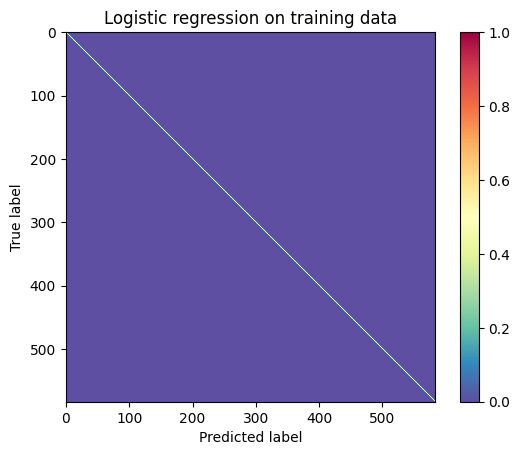

In [26]:
logreg.fit(train_vectors, data_slim["region_variety"])

plot_conf_matrix(
    data_slim["region_variety"],
    predict_top5(logreg, train_vectors, data_slim["region_variety"]),
    "Logistic regression on training data",
    "../img/confusion_matrix_logreg_train.png",
)

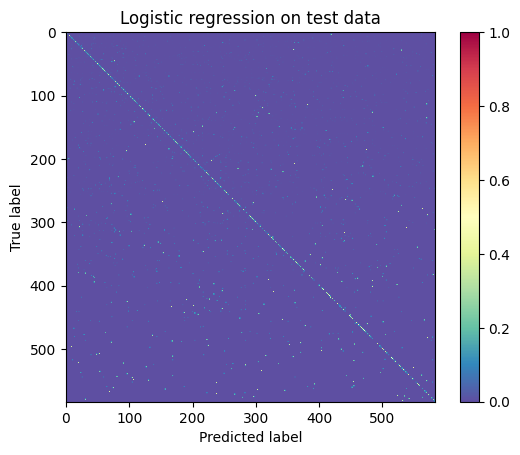

In [27]:
plot_conf_matrix(
    data["test"]["region_variety"],
    predict_top5(logreg, test_vectors, data["test"]["region_variety"]),
    "Logistic regression on test data",
    "../img/confusion_matrix_logreg_test.png",
)

## Some thoughts on stacking strategies:

1. To align with our BERT model, we intentionally selected the top 5 prediction accuracy as our evaluation metrics in training. This is a little tricky. The `make_scorer()` function takes two parameters `needs_proba` and `needs_threshold` which are both `False` by default. But for specific models, we need to turn the parameters on to calculate the similar 
2. We discarded the ensemble models in stacking, since the training time of ensemble models in our case is comparatively long due to the size and feature number of the dataset.

We managed to show the efforts, and would focus more on the report.

Strategies:

1. Level 1 model (meta learner) has to be as simple as possible. A linear model should suffice.
2. Level 0 models should be sequentially decreasing in terms of model performances. An analogue would be stepwise linear model selection from a null model. Specifically, we add the model with the best performance, then the second best to see if it improves, etc.

In [28]:
from sklearn.ensemble import StackingClassifier

level0 = list()
level0.append(("logreg", logreg))
level0.append(("nb", nb))
# level0.append(("svm", svm))
# level0.append(("perceptron", perceptron))
# level0.append(("tree", tree))

level1 = LogisticRegression(
    random_state=random_state, max_iter=60
)  # meta learner uses candidate 1

# A stacking classifier with logistic regression + naïve bayes as level 0 learners, and logistic regression as meta learner.

stacked_ln_l = StackingClassifier(
    estimators=level0, final_estimator=level1, cv=5, n_jobs=-1, passthrough=False
)

# evaluate stacked model

scores["stacked_ln_l"] = eval_model(
    stacked_ln_l, train_vectors, data_slim["region_variety"]
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/rqiu/Library/Caches/pypoetry/virtualenvs/sommelier-app-LnLhopHO-py3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rqiu/Library/Caches/pypoetry/virtualenvs/sommelier-app-LnLhopHO-py3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rqiu/Library/Caches/pypoetry/virtualenvs/sommelier-app-LnLhopHO-py3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rqiu/Library/Caches/pypoetry/virtualenvs/sommelier-app-LnLhopHO-py3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coe

[Train] Top-5 prediction mean accuracy: 0.928 (+/- 0.010)
[Test] Top-5 prediction mean accuracy: 0.499 (+/- 0.007)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


/Users/rqiu/Library/Caches/pypoetry/virtualenvs/sommelier-app-LnLhopHO-py3.9/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/rqiu/Library/Caches/pypoetry/virtualenvs/sommelier-app-LnLhopHO-py3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rqiu/Library/Caches/pypoetry/virtualenvs/sommelier-app-LnLhopHO-py3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


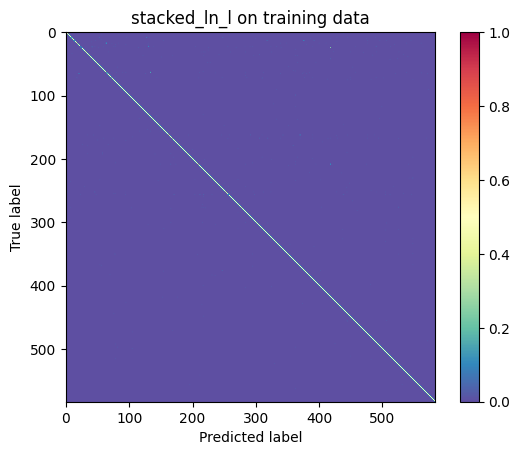

In [29]:
stacked_ln_l.fit(train_vectors, data_slim["region_variety"])

plot_conf_matrix(
    data_slim["region_variety"],
    predict_top5(stacked_ln_l, train_vectors, data_slim["region_variety"]),
    "stacked_ln_l on training data",
    "../img/confusion_matrix_stacked_ln_l_train.png",
)

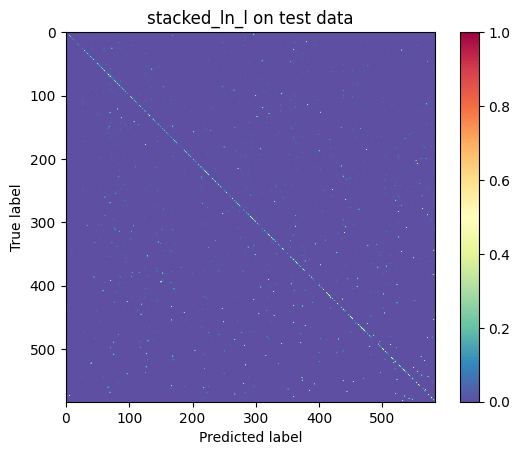

In [30]:
plot_conf_matrix(
    data["test"]["region_variety"],
    predict_top5(stacked_ln_l, test_vectors, data["test"]["region_variety"]),
    "stacked_ln_l on test data",
    "../img/confusion_matrix_stacked_ln_l_test.png",
)

In [31]:
from sklearn.ensemble import StackingClassifier

level0 = list()
level0.append(("logreg", logreg))
# level0.append(("nb", nb))
level0.append(("svm", svm))
# level0.append(("perceptron", perceptron))
# level0.append(("tree", tree))

level1 = LogisticRegression(
    random_state=random_state, max_iter=60
)  # meta learner uses candidate 1

# A stacking classifier with logistic regression + svm as level 0 learners, and logistic regression as meta learner.

stacked_ls_l = StackingClassifier(
    estimators=level0, final_estimator=level1, cv=5, n_jobs=-1, passthrough=False
)

# evaluate stacked model

scores["stacked_ls_l"] = eval_model(
    stacked_ls_l, train_vectors, data_slim["region_variety"]
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/rqiu/Library/Caches/pypoetry/virtualenvs/sommelier-app-LnLhopHO-py3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rqiu/Library/Caches/pypoetry/virtualenvs/sommelier-app-LnLhopHO-py3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rqiu/Library/Caches/pypoetry/virtualenvs/sommelier-app-LnLhopHO-py3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rqiu/Library/Caches/pypoetry/virtualenvs/sommelier-app-LnLhopHO-py3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coe

[Train] Top-5 prediction mean accuracy: 0.978 (+/- 0.005)
[Test] Top-5 prediction mean accuracy: 0.473 (+/- 0.016)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.5min finished


/Users/rqiu/Library/Caches/pypoetry/virtualenvs/sommelier-app-LnLhopHO-py3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rqiu/Library/Caches/pypoetry/virtualenvs/sommelier-app-LnLhopHO-py3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rqiu/Library/Caches/pypoetry/virtualenvs/sommelier-app-LnLhopHO-py3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

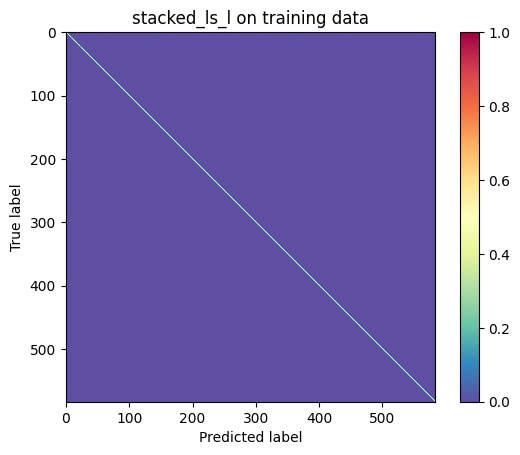

In [32]:
stacked_ls_l.fit(train_vectors, data_slim["region_variety"])

plot_conf_matrix(
    data_slim["region_variety"],
    predict_top5(stacked_ls_l, train_vectors, data_slim["region_variety"]),
    "stacked_ls_l on training data",
    "../img/confusion_matrix_stacked_ls_l_train.png",
)

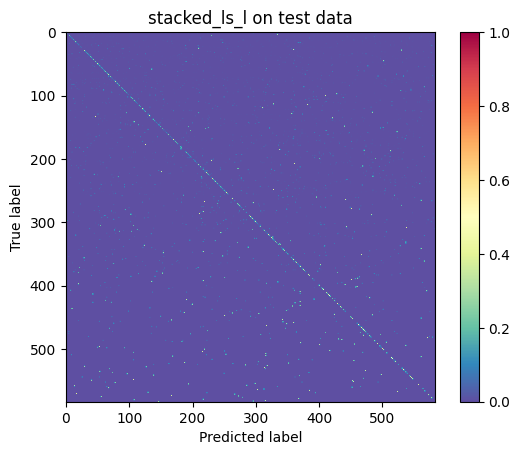

In [33]:
plot_conf_matrix(
    data["test"]["region_variety"],
    predict_top5(stacked_ls_l, test_vectors, data["test"]["region_variety"]),
    "stacked_ls_l on test data",
    "../img/confusion_matrix_stacked_ls_l_test.png",
)

## Model Reproducibility with `pickle`

Although saving the post-training model and loading it again for testing split is required, we decide to do the model evaluation (on both training and testing) with the call of `eval_model()` function. Still, we believe it is necessary to practice the use case of `pickle` as it is a common approach to serialize Python objects.

The following code chunk saves a dictionary of selected model (`stacked_ln_l`) and all model candidates' performance metrics into a `.pkl` file.

In [38]:
import dill

model_summary = {
    "selected_model": stacked_ln_l,
    "scores": scores,
}

with open("../models/model_summary.pkl", "wb") as f:
    dill.dump(model_summary, f)

# Reload the model and the performance metrics

The next two lines will load the object from the `.pkl` file. And it will be used in the next step of this project.

In [39]:
with open("../models/model_summary.pkl", "rb") as f:
    model_summary_reload = dill.load(f)

In [ ]:
stacked_ln_l_reload = model_summary_reload["selected_model"]

In [ ]:
plot_conf_matrix(
    data["test"]["region_variety"],
    predict_top5(stacked_ln_l_reload, test_vectors, data["test"]["region_variety"]),
    "Pickled stacked_ln_l on test data",
    "../img/confusion_matrix_stacked_ln_l_reload.png",
)

# Plot the performance metrics

In [ ]:
# Plot jitter and boxplot of scores in model_summary

import seaborn as sns

sns.set_theme(style="whitegrid")

scores_df = []

for model, score in scores.items():
    for i in range(5):
        d = {"model": model}
        for metric, value in score.items():
            d[metric] = value[i]
        scores_df.append(d)

In [ ]:
bert = {
    "model": "bert*",
    "fit_time": 180,
    "score_time": 2.6,
    "test_score": 0.834,
    "train_score": 0.920,
}
scores_df.append(bert)
scores_df = pd.DataFrame(scores_df)

In [ ]:
def plot_metric(metric, y_name, title, filename):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(x="model", y=metric, data=scores_df, ax=ax)
    sns.stripplot(
        x="model",
        y=metric,
        data=scores_df,
        jitter=0.25,
        size=4,
        ax=ax,
        linewidth=0.2,
    )
    ax.set_title(title)
    ax.set_ylabel(y_name)
    ax.set_xlabel("Model")
    fig.savefig(filename)

In [ ]:
plot_metric(
    "fit_time",
    "Fit time (s)",
    "Fit time of models",
    "../img/metric_fit_time.png",
)

In [ ]:
plot_metric(
    "score_time",
    "Score time (s)",
    "Score time of models",
    "../img/metric_score_time.png",
)

In [ ]:
plot_metric(
    "train_score",
    "Top5 Accuracy",
    "Top5 Accuracy of models on training data",
    "../img/metric_train_score.png",
)

In [ ]:
plot_metric(
    "test_score",
    "Top5 Accuracy",
    "Top5 Accuracy of models on test data",
    "../img/metric_test_score.png",
)